# Data Acquiring

In [1]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [2]:
import os
data_dir = "Alzheimer_s Dataset"
print(os.listdir(data_dir))

['test', 'train']


In [3]:
data_dir += "/train"
print(os.listdir(data_dir))
#C:/Users/acayt/Documents/GitHub/Brain-MRI-Alzheimers-Prediction/Alzheimer_s Dataset/train

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


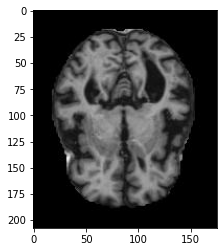

In [4]:
temp_dir = data_dir + "/MildDemented"

import cv2
import matplotlib.pyplot as plt

for img in os.listdir(temp_dir):
    img_array = cv2.imread(os.path.join(temp_dir, img))
    #print(img_array)
    plt.imshow(img_array)
    plt.show()
    break

In [5]:
print(img_array.shape)

(208, 176, 3)


# Data Preprocessing

In [7]:
import tensorflow as tf

In [19]:
# to augment images and create more samples

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.8, 1.2], zoom_range=[0.99, 1.01], horizontal_flip=True, fill_mode="constant", data_format="channels_last")

In [20]:
train_data_gen = image_generator.flow_from_directory(directory=data_dir, target_size=(176, 176), batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


In [21]:
import numpy as np
from random import randint

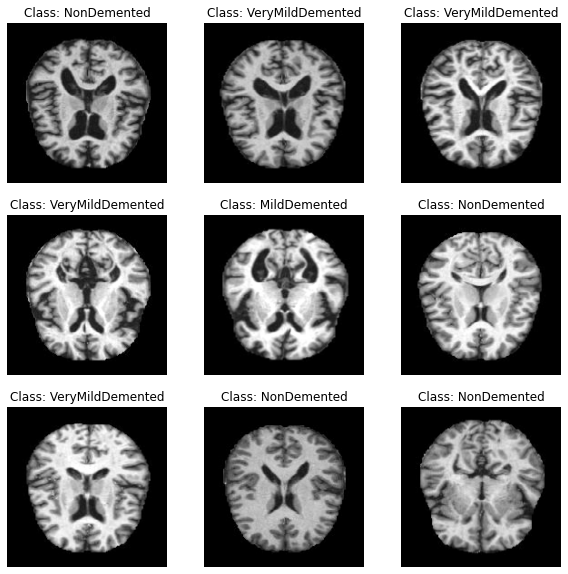

In [24]:
def show_images(generator,y_pred=None):
    #Input: An image generator, predicted labels (optional)
    #Output: Displays a grid of 9 random images with lables
        
    #get image lables
    labels =dict(zip([0,1,2,3], classes))
    
    #get a batch of images
    x,y = generator.next()
    
    #display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 5121) #because there are a total of 5121 images
            plt.imshow(x[idx].astype('uint8')) #This is done because of the reason that if the color intensity is a float,
            #then matplotlib expects it to range from 0 to 1. If an int, then it expects 0 to 255.
            #So we can either force all the numbers to int or scale them all by 1/255 or use the .astype function to cast the object onto our specified dtype.
            plt.axis("off")
            plt.title("Class: {}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i].astype('uint8'))
            plt.axis("off")
            plt.title("Actual: {} \nPredicted: {}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [25]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [6]:
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

for alzheimers_class in classes:
    container = []
    temp_dir = data_dir + "/" + alzheimers_class
    for file in os.listdir(temp_dir):
        container.append(file)
    print(alzheimers_class, ": ", len(container))

MildDemented :  717
ModerateDemented :  52
NonDemented :  2560
VeryMildDemented :  1792


The number of data samples for 'ModerateDemented' is considerably low, compared to the other classes. A clear contrast between the sizes of the training classes shows how imbalanced our classes are. So we'll need to perform over-sampling of the data using SMOTE.

In [28]:
import imblearn

sm = imblearn.over_sampling.SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176, 176, 3)

print(train_data.shape, train_labels.shape)

(10240, 176, 176, 3) (10240, 4)


# Model Training

Going to use multiple types of blocks, multiple times. So I'm just going to define functions for each type of blocks and call them later.

### Convolutional Blocks

In [54]:
def conv_block(filters, act='relu'):    
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters, 3, activation=act, padding='same'))
    block.add(tf.keras.layers.Conv2D(filters, 3, activation=act, padding='same'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.MaxPool2D())
    
    return block

### Normalization Blocks

In [55]:
def norm_block(units, dropout_rate, act='relu'):    
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Dense(units, activation=act))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.Dropout(dropout_rate))
    
    return block

### Sequential Model

In [56]:
def construct_model(act='relu'):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*[176, 176], 3)),
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        norm_block(512, 0.7),
        norm_block(128, 0.5),
        norm_block(64, 0.3),
        tf.keras.layers.Dense(4, activation='softmax') #Output Layer       
    ], name = "cnn_model")

    return model

### Setting Callback

In [44]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [45]:
CALLBACKS = [my_callback]

### Model Compilation

In [59]:
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 176, 176, 16)      448       
                                                                 
 conv2d_23 (Conv2D)          (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 88, 88, 16)       0         
 g2D)                                                            
                                                                 
 sequential_14 (Sequential)  (None, 44, 44, 32)        14016     
                                                                 
 sequential_15 (Sequential)  (None, 22, 22, 64)        55680     
                                                                 
 sequential_16 (Sequential)  (None, 11, 11, 128)       221952    
                                                         